Apply deep learning algorithm LSTM and CNN on gait recognitions based on 22 persons' walking gait data. Data was collected the 3-axis of gyroscope sensors from Android phones.

Data source: Pierluigi Casale, Computer Vision Center, Barcelona:
https://archive.ics.uci.edu/ml/datasets/User+Identification+From+Walking+Activity


Steps:
1. Load raw data and convert data into dataframe
2. Visualize data and remove outliers
3. Data normalization
4. Split dataframe into train and test dataset (every 30 timesteps)
5. Apply one hot encoding for the labels of train and test data
6. Build LSTM model
7. Evaluate LSTM model
8. Build CNN model
9. Evaluate CNN model
10. Conclusions

In [1]:
import numpy as np
from numpy import newaxis
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
import os
from numpy import genfromtxt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/gait/uci/

/content/drive/My Drive/gait/uci


In [4]:
# Number of labels (Number of persons for gait recognitions)
classes = 22

# Split original long signals into smaller data with equal timesteps for later model training and testing
split_periods = 30

In [5]:
def saver(dictex):
    for key, val in dictex.items():
        val.to_csv("{}.csv".format(str(key+classes)))

    with open("keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))

def loader():
    """Reading data from keys"""
    with open("keys.txt", "r") as f:
        keys = eval(f.read())
    print(keys)
    dictex = {} 
    cols = ['timestep', 'x', 'y', 'z']   
    for key in keys:
        # TBD convert to numpy        
        #my_data = genfromtxt("{}.csv".format(str(key)), delimiter=',')
        dictex[key] = pd.read_csv("{}.csv".format(str(key)), names = cols)
        
    return dictex

In [6]:
# Split each data sample file (dataframe) into seperate dataframes 
def split_signal(df, periods):
    i = 0
    x_df_i = {}
    # number of split dataframes
    n = int(df.shape[0]/periods)
    for i in range(n):
        start = i*periods
        end = (i+1)*periods
        x_df_i[i] = df[start:end]
    return x_df_i, n

In [7]:
def rem_outliers(df, b_truncate = False, lo = 0, hi = 10000):
  if b_truncate:  
    b_range = (df['timestep'] > lo) & (df['timestep'] < hi)
    df_sig = df.loc[b_range, :]
  else:
    df_sig = df
  ax = df_sig.plot(x = 'timestep', y = ['x', 'y', 'z'], figsize = (20,5), grid = True)
  plt.xticks(rotation = 30)
  plt.show()
  df_sig.reset_index(drop = True, inplace = True)
  return df_sig

In [8]:
df = loader()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


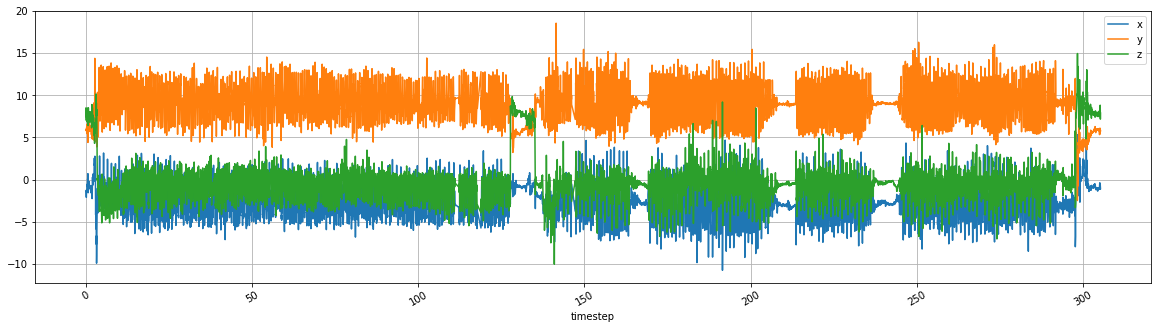

In [9]:
df[0] = rem_outliers(df[0], b_truncate = False)

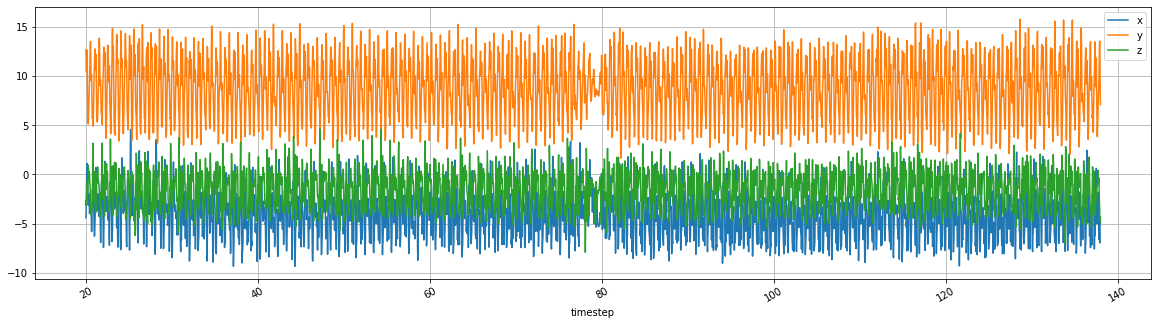

In [10]:
df[1] = rem_outliers(df[1], b_truncate = True, lo = 20, hi = 138)

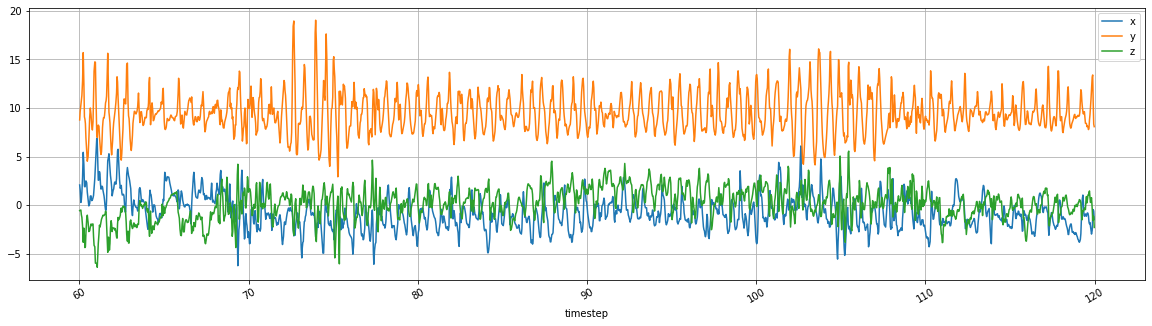

In [11]:
df[2] = rem_outliers(df[2], b_truncate = True, lo = 60, hi = 120)

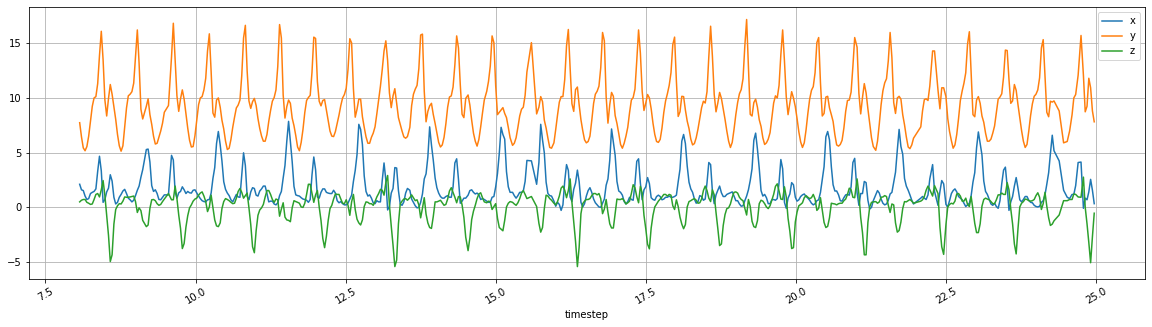

In [12]:
df[3] = rem_outliers(df[3], b_truncate = True, lo = 8, hi = 25)

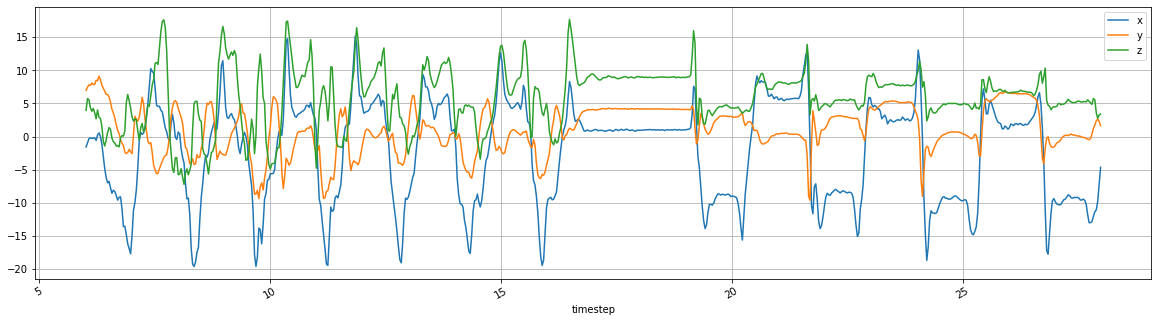

In [13]:
df[5] = rem_outliers(df[5], b_truncate = True, lo = 6, hi = 28)

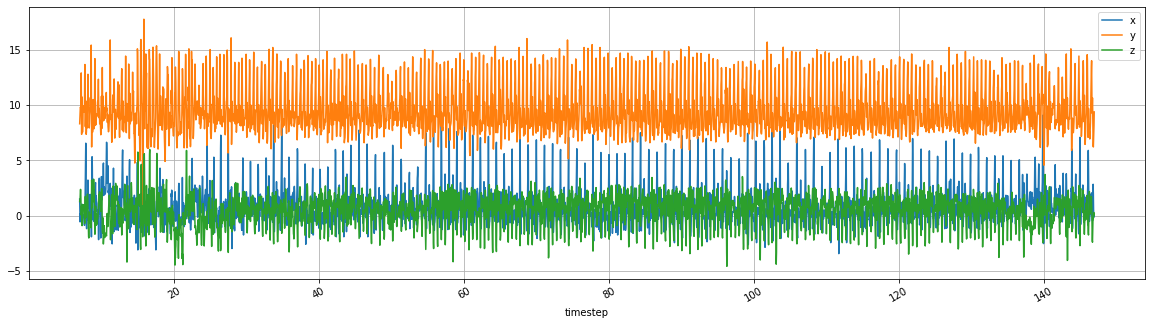

In [14]:
df[6] = rem_outliers(df[6], b_truncate = True, lo = 7, hi = 147)

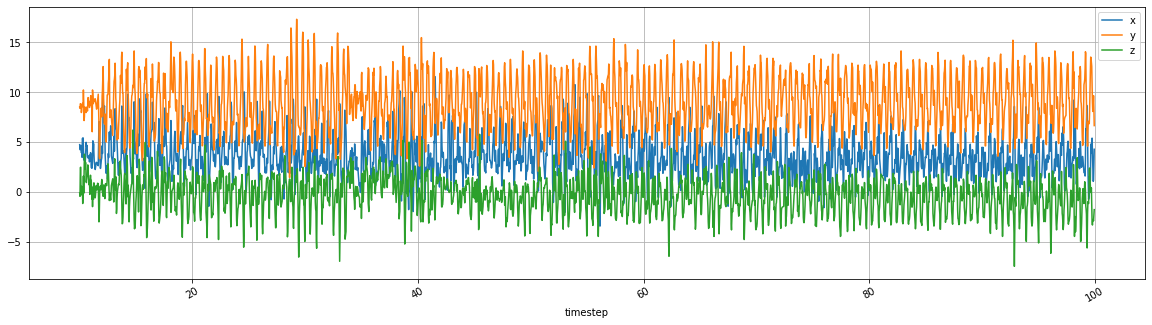

In [15]:
df[7] = rem_outliers(df[7], b_truncate = True, lo = 10, hi = 100)

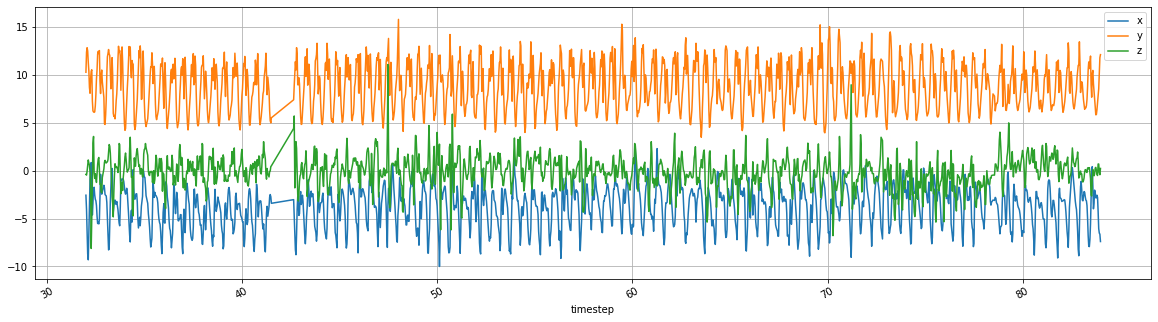

In [16]:
df[8] = rem_outliers(df[8], b_truncate = True, lo = 32, hi = 84)

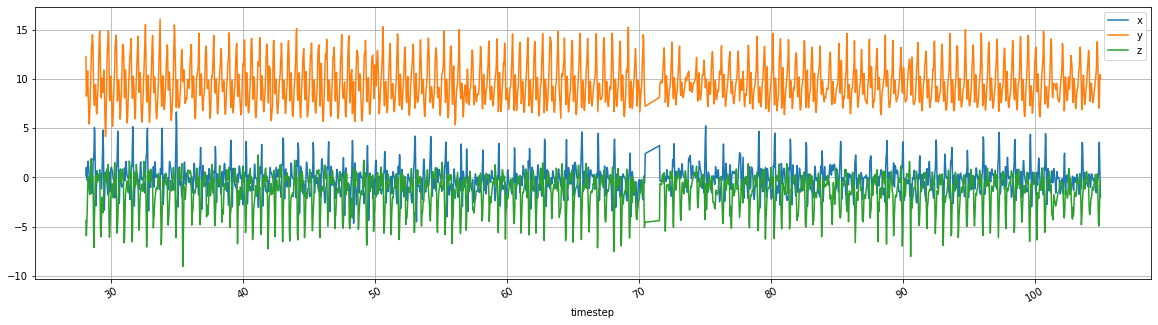

In [17]:
df[9] = rem_outliers(df[9], b_truncate = True, lo = 28, hi = 105)

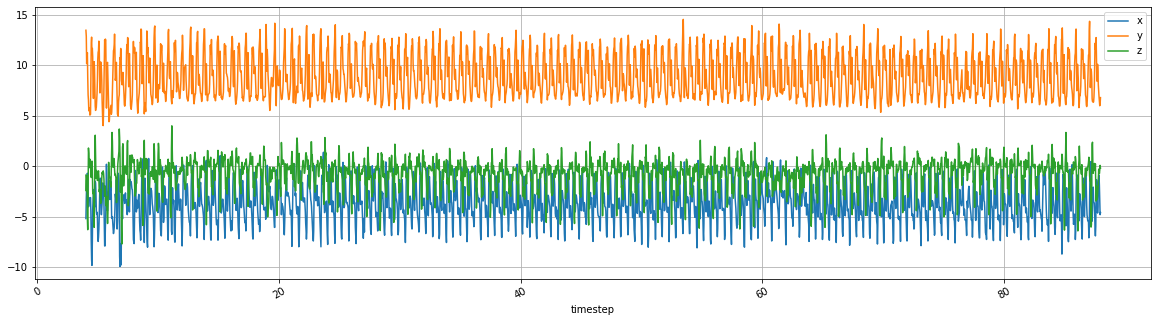

In [18]:
df[10] = rem_outliers(df[10], b_truncate = True, lo = 4, hi = 88)

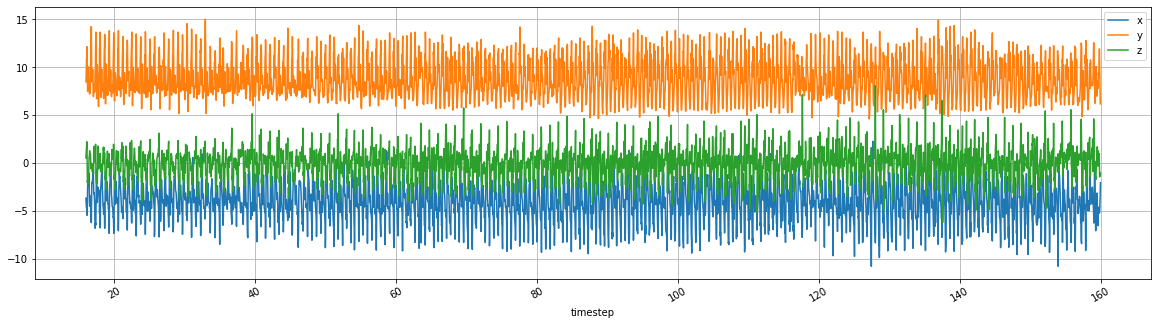

In [19]:
df[11] = rem_outliers(df[11], b_truncate = True, lo = 16, hi = 160)

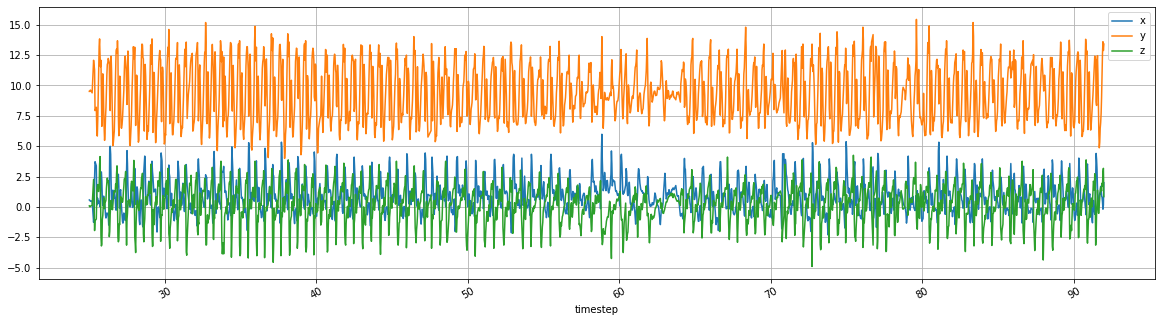

In [20]:
df[12] = rem_outliers(df[12], b_truncate = True, lo = 25, hi = 92)

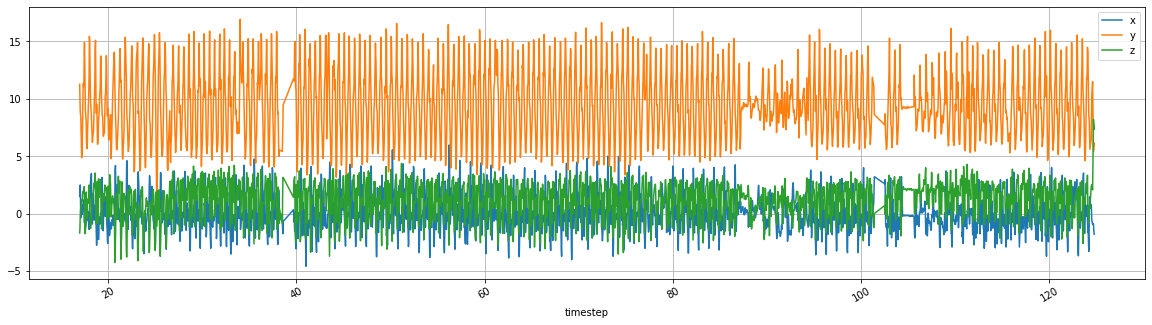

In [21]:
df[13] = rem_outliers(df[13], b_truncate = True, lo = 17, hi = 125)

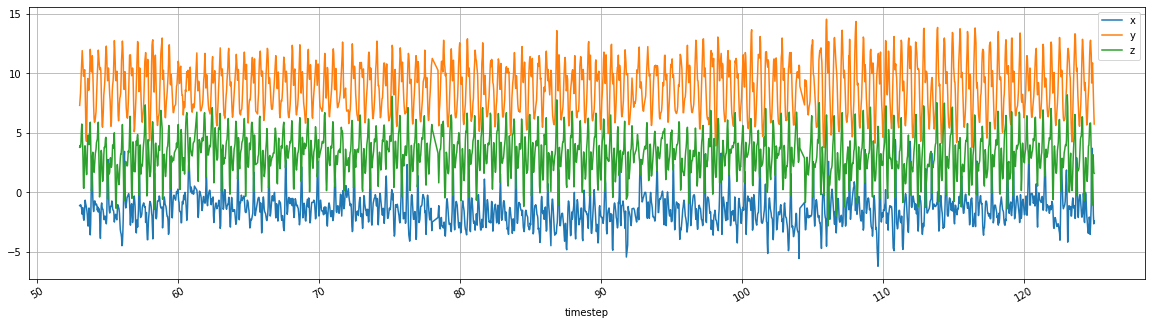

In [22]:
df[14] = rem_outliers(df[14], b_truncate = True, lo = 53, hi = 125)

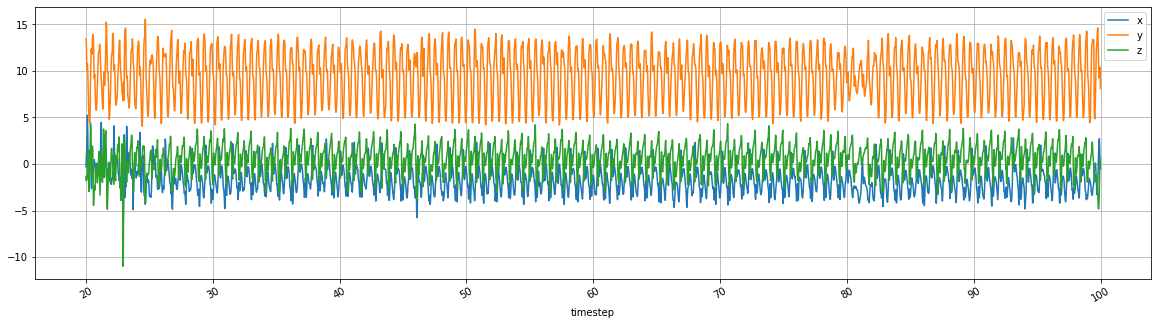

In [23]:
df[15] = rem_outliers(df[15], b_truncate = True, lo = 20, hi = 100)

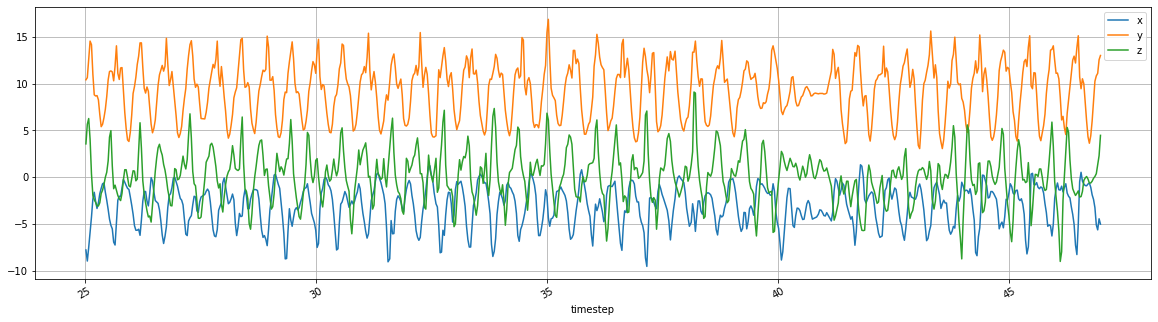

In [24]:
df[16] = rem_outliers(df[16], b_truncate = True, lo = 25, hi = 47)

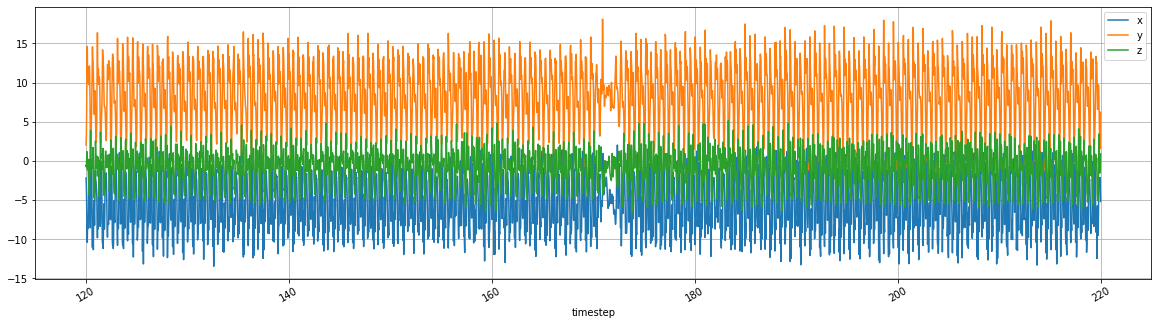

In [25]:
df[17] = rem_outliers(df[17], b_truncate = True, lo = 120, hi = 220)

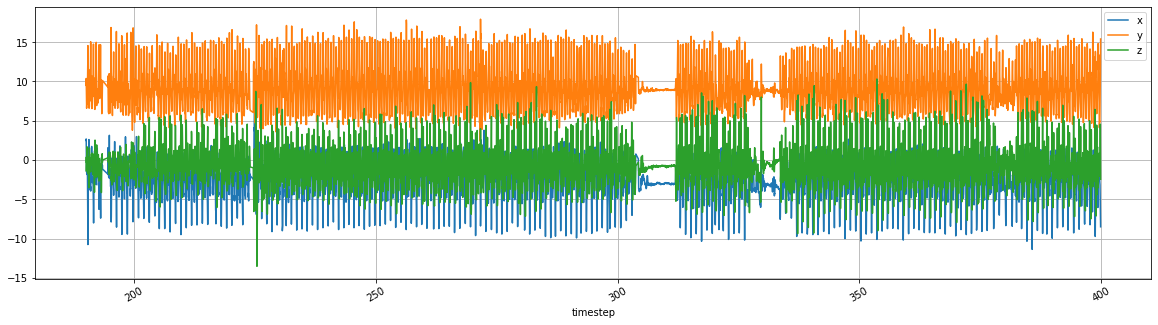

In [26]:
df[18] = rem_outliers(df[18], b_truncate = True, lo = 190, hi = 400)

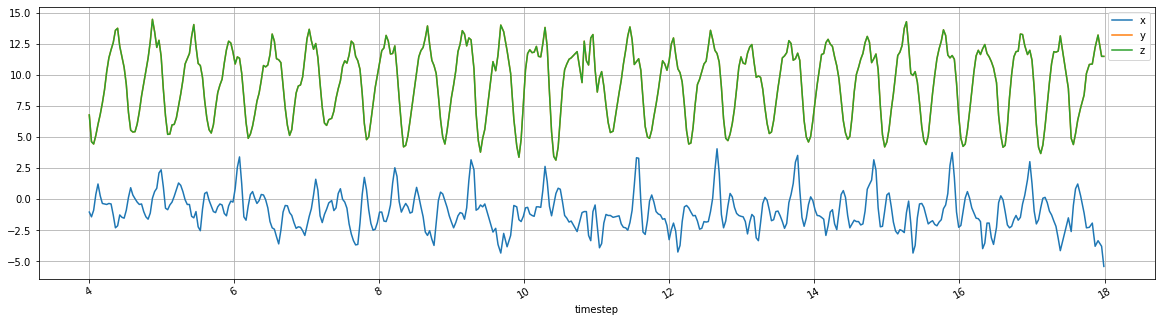

In [27]:
df[19] = rem_outliers(df[19], b_truncate = True, lo = 4, hi = 18)

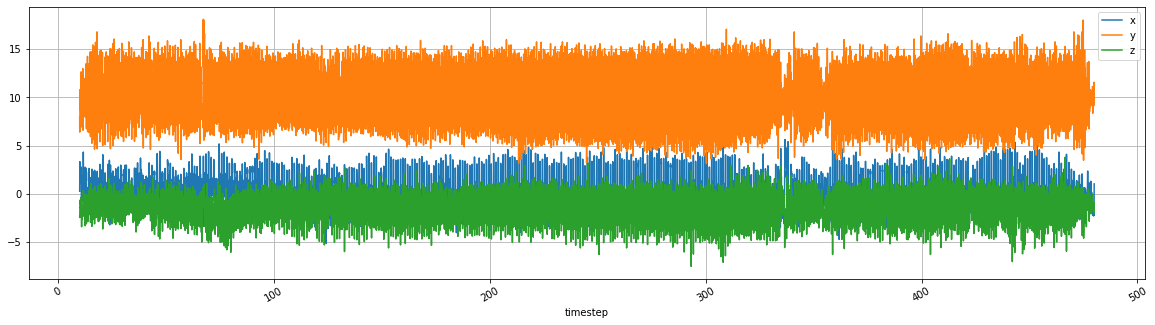

In [28]:
df[20] = rem_outliers(df[20], b_truncate = True, lo = 10, hi = 480)

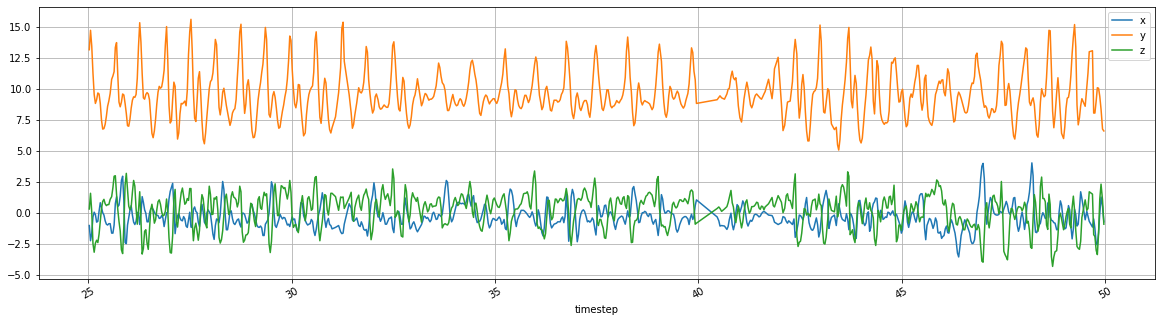

In [29]:
df[21] = rem_outliers(df[21], b_truncate = True, lo = 25, hi = 50)

In [30]:
for i in range(classes):
  print('class', i, ': ')
  print(df[i].shape[0])
  df[i].drop(columns = 'timestep', inplace = True) 

class 0 : 
9698
class 1 : 
3911
class 2 : 
1897
class 3 : 
544
class 4 : 
6981
class 5 : 
700
class 6 : 
4600
class 7 : 
2872
class 8 : 
1674
class 9 : 
2467
class 10 : 
2751
class 11 : 
4685
class 12 : 
2149
class 13 : 
3379
class 14 : 
2321
class 15 : 
2643
class 16 : 
724
class 17 : 
3312
class 18 : 
6786
class 19 : 
449
class 20 : 
15567
class 21 : 
779


In [31]:
# Normalization
all_df = pd.DataFrame()

# Find individual means and standard deviations for each parameter
for i in range(classes):
  all_df = pd.concat([all_df, df[i][['x','y','z']]])

data_mean = all_df.mean(axis = 0)
data_std = all_df.std(axis = 0)
print(data_mean)
print(data_std)

for i in range(classes):
  df[i] = (df[i] - data_mean)/data_std

x   -1.708915
y    9.100700
z   -0.185907
dtype: float64
x    2.879318
y    2.751275
z    2.389169
dtype: float64


In [32]:
# 1. split data into data with smaller (30) timesteps 2. Split data into training and test set
df_train = {}
df_test = {}
d = pd.DataFrame()
X_train = np.array([]) 
X_test = np.array([])
# Number of training examples for each person after traiing/ test split
n_train = {}
n_test = {}

for i in range(classes):
    print('i:', i)
    x_dic, n  = split_signal(df[i], periods = split_periods)
    print('n=', n)
    n_split = int(0.8*n)
    n_train[i] = n_split
    n_test[i] = n - n_split
    print('test_split=', n_split)
        
    # Handle each person's data after data split
    # Generate training data
    for j in range(n_split):
      # Convert dataframe to numpy
      np_train = x_dic[j].to_numpy()
      np_train = np_train[newaxis, :, :]
        
      if (i == 0) and (j == 0):
        X_train = np_train
      else:
        X_train = np.concatenate((X_train, np_train), axis = 0)      
        
    # Generate test data
    for j in range(n_split, n):
      np_test = x_dic[j].to_numpy()
      np_test = np_test[newaxis, :, :]
      if (i == 0) and (j == n_split):
        X_test = np_test
      else:
        X_test = np.concatenate((X_test, np_test), axis=0)
    print('X_train shape:', X_train.shape)
    print('X_test shape:', X_test.shape)

i: 0
n= 323
test_split= 258
X_train shape: (258, 30, 3)
X_test shape: (65, 30, 3)
i: 1
n= 130
test_split= 104
X_train shape: (362, 30, 3)
X_test shape: (91, 30, 3)
i: 2
n= 63
test_split= 50
X_train shape: (412, 30, 3)
X_test shape: (104, 30, 3)
i: 3
n= 18
test_split= 14
X_train shape: (426, 30, 3)
X_test shape: (108, 30, 3)
i: 4
n= 232
test_split= 185
X_train shape: (611, 30, 3)
X_test shape: (155, 30, 3)
i: 5
n= 23
test_split= 18
X_train shape: (629, 30, 3)
X_test shape: (160, 30, 3)
i: 6
n= 153
test_split= 122
X_train shape: (751, 30, 3)
X_test shape: (191, 30, 3)
i: 7
n= 95
test_split= 76
X_train shape: (827, 30, 3)
X_test shape: (210, 30, 3)
i: 8
n= 55
test_split= 44
X_train shape: (871, 30, 3)
X_test shape: (221, 30, 3)
i: 9
n= 82
test_split= 65
X_train shape: (936, 30, 3)
X_test shape: (238, 30, 3)
i: 10
n= 91
test_split= 72
X_train shape: (1008, 30, 3)
X_test shape: (257, 30, 3)
i: 11
n= 156
test_split= 124
X_train shape: (1132, 30, 3)
X_test shape: (289, 30, 3)
i: 12
n= 71
test

In [33]:
print(X_train.shape)
print(X_test.shape)

(2140, 30, 3)
(546, 30, 3)


In [34]:
# Create y_train, y_test: (None, 22) one hot encoding
train_axis_0_ind = 0
test_axis_0_ind = 0
n_train_split = X_train.shape[0]
n_test_split = X_test.shape[0]
y_train = np.zeros((n_train_split, classes))
y_test = np.zeros((n_test_split, classes))

# Total splits for training data
for i in range(classes):
  print('i', i)
  for j in range(n_train[i]):
    y_train[train_axis_0_ind][i] = 1
    train_axis_0_ind += 1
  for j in range(n_test[i]):
    y_test[test_axis_0_ind][i] = 1
    test_axis_0_ind += 1        

i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21


In [35]:
print(y_train.shape)
print(y_test.shape)

(2140, 22)
(546, 22)


In [36]:
# Build LSTM model
# best: loss: 0.4342 - accuracy: 0.8556 - val_loss: 0.5291 - val_accuracy: 0.8516
model_lstm = keras.Sequential([
    tf.keras.layers.LSTM(units = 128, activation = 'tanh', return_sequences = True, dropout = 0.5, recurrent_dropout = 0.5),
    tf.keras.layers.LSTM(units = 128, activation = 'tanh', return_sequences = True, dropout = 0.6, recurrent_dropout = 0.5),
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(units = 64),
    tf.keras.layers.Dense(64, activation='tanh', kernel_initializer = tf.initializers.zeros()),
    tf.keras.layers.Dropout(0.4),    
    tf.keras.layers.Dense(units = classes, activation = 'softmax'),
])

In [37]:
opt = keras.optimizers.Adam(learning_rate=0.0004)
model_lstm.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights = True)
tb_callback = tf.keras.callbacks.TensorBoard()

In [38]:
n_epochs = 300
history = model_lstm.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = n_epochs, batch_size = 32, verbose=1, callbacks = [stop_callback, tb_callback])

Epoch 1/300
67/67 [==============================] - 29s 257ms/step - loss: 2.6139 - accuracy: 0.2860 - val_loss: 2.1278 - val_accuracy: 0.3535
Epoch 2/300
67/67 [==============================] - 16s 239ms/step - loss: 2.0220 - accuracy: 0.3547 - val_loss: 1.7946 - val_accuracy: 0.4432
Epoch 3/300
67/67 [==============================] - 16s 244ms/step - loss: 1.8448 - accuracy: 0.3967 - val_loss: 1.7866 - val_accuracy: 0.4139
Epoch 4/300
67/67 [==============================] - 16s 241ms/step - loss: 1.7968 - accuracy: 0.4117 - val_loss: 1.6955 - val_accuracy: 0.4176
Epoch 5/300
67/67 [==============================] - 16s 246ms/step - loss: 1.7406 - accuracy: 0.4173 - val_loss: 1.5822 - val_accuracy: 0.4322
Epoch 6/300
67/67 [==============================] - 16s 241ms/step - loss: 1.6681 - accuracy: 0.4112 - val_loss: 1.5306 - val_accuracy: 0.5128
Epoch 7/300
67/67 [==============================] - 16s 239ms/step - loss: 1.6231 - accuracy: 0.4374 - val_loss: 1.4301 - val_accuracy:

In [39]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           67584     
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 22)                1430      
                                                                 
Total params: 254,166
Trainable params: 254,166
Non-trai

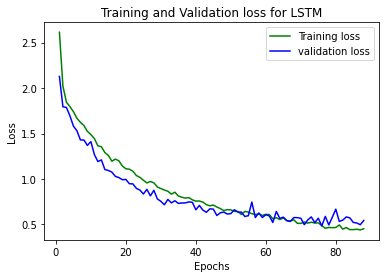

In [40]:
# Get total epochs for training
n_epochs = len(history.history['loss'])
# Draw epoch vs. loss chart for training and validation data
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,n_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

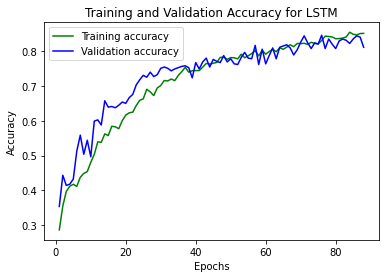

In [41]:
# Draw epoch vs. accuracy chart for training and validation data
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,n_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy for LSTM')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [42]:
# Display the numbers of test set for each person's data
for i in range(classes):
  print(n_test[i])

65
26
13
4
47
5
31
19
11
17
19
32
15
23
16
18
5
22
46
3
104
5


In [43]:
print(X_test.shape)

(546, 30, 3)


In [44]:
# Calculate the individual accuracies for each person on test set
pred = model_lstm.predict(X_test)
n_bingo = 0
n_samples = y_test.shape[0]
class_change = False
class_id = 0
accuracy = []

for j in range(n_samples):
  actual = np.argmax(y_test[j])
  prediction = np.argmax(pred[j]) 
  
  # Check if class is changed
  if actual != class_id:
    accuracy.append(n_bingo/n_test[class_id])
    
    class_id = actual
    # reset accuracy count for new class
    n_bingo = 0    
  else:
    n_bingo += 1
# for the last class
accuracy.append(n_bingo/n_test[class_id])

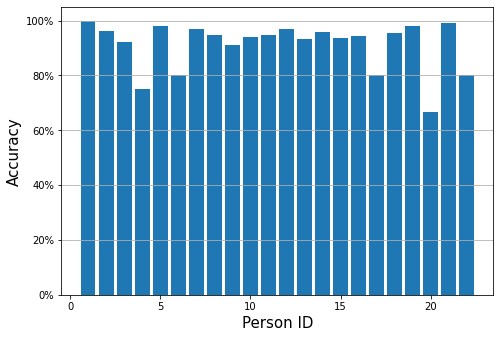

In [45]:
# Show the individual accuracies for each person on test set
y = list(np.array(accuracy)*100)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
person_id = list(range(1, classes+1))
ax.bar(person_id, y)
ax.grid(axis='y')
plt.xlabel("Person ID", size=15)
plt.ylabel("Accuracy", size=15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

In [46]:
# Build CNN model
# X_train: (2140, 30, 3)), X_test:(546, 30, 3)
# y_train:(2140, 22) y_test:(546, 22)
model_cnn = keras.Sequential([
      layers.Conv2D(filters=8, kernel_size=(1,3), activation='relu', strides=[1,2], input_shape=[30,3,1]),
      layers.Conv2D(filters=16, kernel_size=(3,1), activation='relu', strides=[1,2]),           
      layers.MaxPool2D(pool_size=(2,1), strides=(1,1), padding='valid'),
      layers.Dropout(0.2),
      layers.Conv2D(filters=32, kernel_size=(3,1), activation='relu', strides=[1,2], padding='SAME'),
      layers.MaxPool2D(pool_size=(2,1), strides=(1,1), padding='valid'),      
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dropout(0.1),      
      layers.Dense(32, activation='relu'), 
      layers.Dense(22, activation='softmax') 
    ])

In [47]:
opt = keras.optimizers.Adam(learning_rate=0.0005)
model_cnn.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=16, restore_best_weights = True)

In [48]:
n_epochs = 300
history = model_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=n_epochs, batch_size=32, verbose=1, callbacks=[stop_callback])

Epoch 1/300
67/67 [==============================] - 9s 9ms/step - loss: 2.8930 - accuracy: 0.1752 - val_loss: 2.6294 - val_accuracy: 0.2985
Epoch 2/300
67/67 [==============================] - 0s 5ms/step - loss: 2.3224 - accuracy: 0.3332 - val_loss: 2.1030 - val_accuracy: 0.4377
Epoch 3/300
67/67 [==============================] - 0s 4ms/step - loss: 1.9572 - accuracy: 0.3991 - val_loss: 1.8299 - val_accuracy: 0.4487
Epoch 4/300
67/67 [==============================] - 0s 5ms/step - loss: 1.7387 - accuracy: 0.4350 - val_loss: 1.6728 - val_accuracy: 0.4963
Epoch 5/300
67/67 [==============================] - 0s 5ms/step - loss: 1.5732 - accuracy: 0.4794 - val_loss: 1.5064 - val_accuracy: 0.5275
Epoch 6/300
67/67 [==============================] - 0s 5ms/step - loss: 1.4402 - accuracy: 0.5061 - val_loss: 1.4219 - val_accuracy: 0.5531
Epoch 7/300
67/67 [==============================] - 0s 5ms/step - loss: 1.3196 - accuracy: 0.5575 - val_loss: 1.3497 - val_accuracy: 0.5934
Epoch 8/300
6

In [49]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 1, 8)          32        
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 1, 16)         400       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 1, 16)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 27, 1, 16)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 1, 32)         1568      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 1, 32)        0         
 2D)                                                  

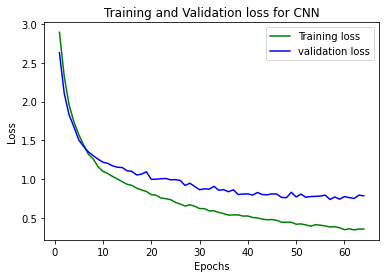

In [50]:
# Get total epochs for training
n_epochs = len(history.history['loss'])
# Draw epoch vs. loss chart for training and validation data
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,n_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

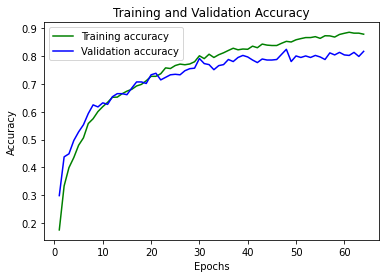

In [51]:
# Draw epoch vs. accuracy chart for training and validation data
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,n_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [52]:
# Calculate the individual accuracies for each person on test set
pred = model_cnn.predict(X_test)
n_bingo = 0
n_samples = y_test.shape[0]
class_change = False
class_id = 0
accuracy = []

for j in range(n_samples):
  actual = np.argmax(y_test[j])
  prediction = np.argmax(pred[j]) 
  
  # Check if class is changed
  if actual != class_id:
    accuracy.append(n_bingo/n_test[class_id])
    
    class_id = actual
    # reset accuracy count for new class
    n_bingo = 0    
  else:
    n_bingo += 1
# for the last class
accuracy.append(n_bingo/n_test[class_id])

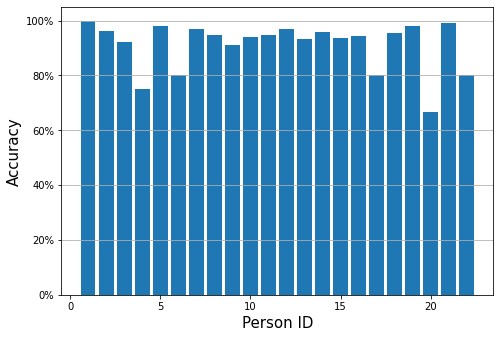

In [53]:
# Show the individual accuracies for each person on test set
y = list(np.array(accuracy)*100)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
person_id = list(range(1, classes+1))
ax.bar(person_id, y)
ax.grid(axis='y')
plt.xlabel("Person ID", size=15)
plt.ylabel("Accuracy", size=15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

Conclusions:
1. LSTM has the better accuracy over CNN for the gait recognition data:
LSTM:
val_loss: 0.4980 - val_accuracy: 0.8443 at epoch 71
CNN:
val_loss: 0.7605 - val_accuracy: 0.8242 at epoch 48


2. Persons with fewer timesteps such as person_id = 4, 6, 20. Data interpolation has been tried but result is not improved, so this step has been removed. Will apply other augmentations.
3. It's worth trying to add accelerometer signals in x,y,z directions for gait recognitions to improve the test accuracies.